In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, confusion_matrix, accuracy_score, roc_auc_score,
                             average_precision_score, make_scorer, recall_score)
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/root/DATA/cleaned_final_dataset.csv')
data = data.drop(columns=['subject_id', 'icustay_id', 'hadm_id'], errors='ignore')
X = data.drop(columns=['expire_flag'])
y = data['expire_flag']
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the logistic regression model and hyperparameters
model = LogisticRegression(random_state=42)
param_grid = {
    'C': [10, 100],
    'solver': ['saga'],
    'penalty': ['elasticnet'],
    'class_weight': [{1: 0.8, 0: 0.2}, {1: 0.7, 0: 0.3}],
    'l1_ratio': [0.5, 0.7],
    'max_iter': [5000]
}
scoring = make_scorer(roc_auc_score, response_method="predict_proba")
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Display best parameters
print(f"\nBest Hyperparameters: {grid_search.best_params_}")

# Best model and predictions
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
y_train_prob = best_model.predict_proba(X_train_scaled)[:, 1]
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Function to compute 95% CI
def compute_ci(scores, alpha=0.95):
    mean_score = np.mean(scores)
    std_dev = np.std(scores)
    z_score = norm.ppf(1 - (1 - alpha) / 2)
    ci_lower = mean_score - z_score * (std_dev / np.sqrt(len(scores)))
    ci_upper = mean_score + z_score * (std_dev / np.sqrt(len(scores)))
    return f"{mean_score:.4f} ({ci_lower:.4f}, {ci_upper:.4f})"

# Bootstrapping for AUROC confidence intervals
def bootstrap_metric_ci(metric_func, y_true, y_prob, n_bootstraps=1000):
    bootstrapped_scores = []
    np.random.seed(42)
    for i in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        score = metric_func(y_true.iloc[indices], y_prob[indices])
        bootstrapped_scores.append(score)
    return compute_ci(bootstrapped_scores)

# Calculate metrics and CIs
train_auroc_ci = bootstrap_metric_ci(roc_auc_score, y_train, y_train_prob)
test_auroc_ci = bootstrap_metric_ci(roc_auc_score, y_test, y_test_prob)
train_auprc = average_precision_score(y_train, y_train_prob)
test_auprc = average_precision_score(y_test, y_test_prob)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Sensitivity and Specificity
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
train_sensitivity, train_specificity = calculate_sensitivity_specificity(confusion_train)
test_sensitivity, test_specificity = calculate_sensitivity_specificity(confusion_test)

# Summary table
summary_data = {
    "Metric": ["AUROC (95% CI)", "AUPRC", "F1 Score", "Accuracy", "Sensitivity", "Specificity"],
    "Training cohort": [train_auroc_ci, f"{train_auprc:.4f}", f"{train_f1:.4f}", f"{train_accuracy:.4f}", f"{train_sensitivity:.4f}", f"{train_specificity:.4f}"],
    "Testing cohort": [test_auroc_ci, f"{test_auprc:.4f}", f"{test_f1:.4f}", f"{test_accuracy:.4f}", f"{test_sensitivity:.4f}", f"{test_specificity:.4f}"]
}

# Create DataFrame and print
summary_df = pd.DataFrame(summary_data)
print(summary_df)


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Hyperparameters: {'C': 10, 'class_weight': {1: 0.7, 0: 0.3}, 'l1_ratio': 0.7, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
           Metric          Training cohort           Testing cohort
0  AUROC (95% CI)  0.7523 (0.7521, 0.7526)  0.7487 (0.7482, 0.7491)
1           AUPRC                   0.6647                   0.6547
2        F1 Score                   0.6475                   0.6447
3        Accuracy                   0.6366                   0.6348
4     Sensitivity                   0.8302                   0.8238
5     Specificity                   0.5065                   0.5077



Classification Report - Training Set:
              precision    recall  f1-score   support

           0       0.82      0.51      0.63      9588
           1       0.53      0.83      0.65      6447

    accuracy                           0.64     16035
   macro avg       0.67      0.67      0.64     16035
weighted avg       0.70      0.64      0.63     16035


Confusion Matrix - Training Set:


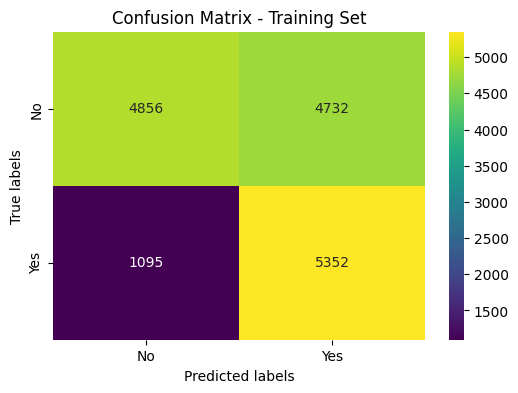

In [14]:
# 17. Print classification reports for both sets
print("\nClassification Report - Training Set:")
print(classification_report(y_train, y_train_pred))

# 18.Plot confusion matrices for training and testing sets
print("\nConfusion Matrix - Training Set:")
plot_confusion_matrix(confusion_train, "Training Set")



Classification Report - Testing Set:
              precision    recall  f1-score   support

           0       0.81      0.51      0.62      2397
           1       0.53      0.82      0.64      1612

    accuracy                           0.63      4009
   macro avg       0.67      0.67      0.63      4009
weighted avg       0.70      0.63      0.63      4009


Confusion Matrix - Testing Set:


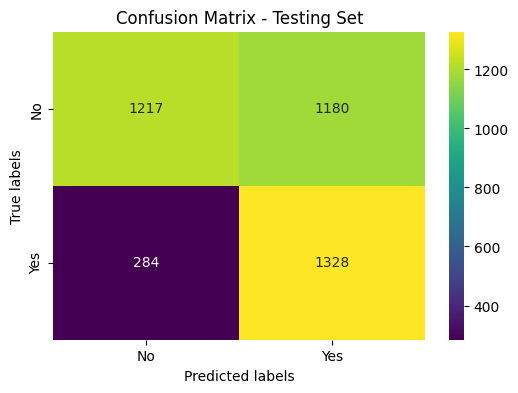

In [15]:
print("\nClassification Report - Testing Set:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix - Testing Set:")
plot_confusion_matrix(confusion_test, "Testing Set")


In [26]:
# Save the predicted probabilities and true labels for the training and testing sets
train_results = pd.DataFrame({
    "True_Label": y_train,
    "Predicted_Probability": y_train_prob
})

test_results = pd.DataFrame({
    "True_Label": y_test,
    "Predicted_Probability": y_test_prob
})

# Save data to CSV files
train_results.to_csv('/root/DATA/train_results_logistic.csv', index=False)
test_results.to_csv('/root/DATA/test_results_logistic.csv', index=False)

print("Predicted results for the training and testing sets have been saved to CSV files.")


Predicted results for the training and testing sets have been saved to CSV files.
